In [249]:
import os
import cv2
import numpy as np
import pandas as pd


from PIL import Image, ImageDraw
from sklearn.model_selection import train_test_split

import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch import optim
from torchvision.models import resnet18
from torchvision.models import ResNet18_Weights
from torchvision.ops import box_iou, distance_box_iou_loss


from pathlib import Path
import re

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Load data

In [3]:
data_path = Path('./data/')
dogs = pd.read_csv(data_path / 'bounding_boxes.csv', index_col=0, names=['path', 'xc', 'yc', 'boxw', 'boxh'])

In [4]:
dogs['label'] = dogs['path'].apply(lambda s: re.findall('-[\w-]*/n', s)[0][1:-2])

In [5]:
dogs.head()

,path,xc,yc,boxw,boxh,label
1,n02085620-Chihuahua/n02085620_10074.jpg,150.5,254.0,251.0,488.0,Chihuahua
2,n02085620-Chihuahua/n02085620_10131.jpg,221.0,251.0,344.0,484.0,Chihuahua
3,n02085620-Chihuahua/n02085620_10621.jpg,238.5,146.5,193.0,207.0,Chihuahua
4,n02085620-Chihuahua/n02085620_1073.jpg,156.0,262.5,312.0,471.0,Chihuahua
5,n02085620-Chihuahua/n02085620_10976.jpg,166.0,278.0,152.0,348.0,Chihuahua


In [6]:
non_dogs_path = ['non_dogs/' + p for p in os.listdir('./data/images/non_dogs/')]
zeros = [0] * len(non_dogs_path)

In [7]:
non_dogs = pd.DataFrame({'path': non_dogs_path, 'xc': zeros, 'yc': zeros, 'boxh': zeros, 'boxw': zeros, 'label': 'Non_dog'})

In [8]:
bboxes = pd.concat((dogs, non_dogs), ignore_index=True)

## Create dataloaders

In [9]:
ID2LABEL = bboxes['label'].unique()
LABEL2ID = dict((label, i) for i, label in enumerate(ID2LABEL))

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

In [10]:
class Data(Dataset):
    def __init__(self, data, img_folder="./data/images/"):
        self.path = data['path'].values
        self.bboxes = data[['xc', 'yc', 'boxw', 'boxh']].values
        self.labels = data['label'].values
        self.img_folder = Path(img_folder)

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(MEAN, STD),
        ])

    def __getitem__(self, idx):
        image = np.array(Image.open(self.img_folder / self.path[idx]))
        if len(image.shape) == 2:
            image = image[..., np.newaxis]
        if image.shape[-1] == 1:
            image = np.concatenate((image, image, image), 2)
        if self.labels[idx] == "Non_dog":
            image = image[:, :, ::-1].copy()
        if image.shape[-1] == 4:
            image = image[:, :, :3].copy()
        shape = image.shape[:2][::-1]
        bbox = torch.tensor(self.bboxes[idx]) / torch.Tensor([image.shape[1], image.shape[0], image.shape[1], image.shape[0]]) 
        image = self.transform(Image.fromarray(image))
        label = torch.tensor(LABEL2ID[self.labels[idx]])
        item = {'image': image, 'label': label, 'bbox': bbox, 'shape': shape}
        return item
    
    def __len__(self):
        return len(self.labels)

In [11]:
data = Data(bboxes)

In [50]:
def to_img(inp):
    mean = np.array(MEAN)
    std = np.array(STD)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp * 255


def draw_image_with_bbox(im, shape, gt_bbox, gt_label, pred_bbox=None, pred_obj=1):
    gt_bbox = np.clip(gt_bbox, 0, 1)
    xc, yc, w, h = gt_bbox
    gt_label = ID2LABEL[gt_label]
    im = im.numpy().transpose((1, 2, 0))
    im = cv2.resize(im, dsize=shape)
    xmin = (xc - w / 2) * shape[0]
    ymin = (yc - h / 2) * shape[1]
    w = w * shape[0]
    h = h * shape[1]
    xmin, ymin, w, h = map(int, [xmin, ymin, w, h])
    image_with_bbox = Image.fromarray(to_img(im).astype(np.uint8))
    image_draw = ImageDraw.Draw(image_with_bbox)
    image_draw.rectangle((max(xmin, 1), max(ymin, 1), min(xmin+w, shape[0] - 1), min(ymin+h, shape[1] - 1)), outline='green')

    if pred_bbox != None:
        xc, yc, w, h = pred_bbox
        xmin = (xc - w / 2) * shape[0]
        ymin = (yc - h / 2) * shape[1]
        w = w * shape[0]
        h = h * shape[1]
        xmin, ymin, w, h = map(int, [xmin, ymin, w, h])
        if pred_obj > 0.5:
            image_draw.rectangle((max(xmin, 1), max(ymin, 1), min(xmin+w, shape[0] - 1), min(ymin+h, shape[1] - 1)), outline='red')

    return image_with_bbox

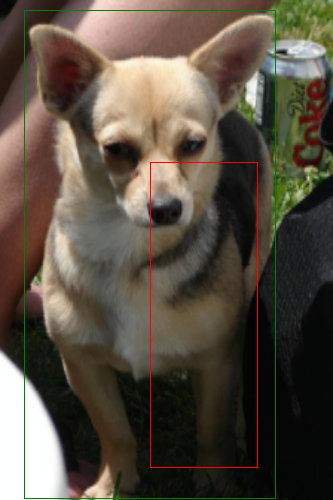

In [51]:
im = data[0]['image']
bbox = data[0]['bbox']
shape = data[0]['shape']
label = data[0]['label']
pred_bbox = data[1000]['bbox'] # consider that it is predicted bounding box
pred_label = data[1000]['label']
draw_image_with_bbox(im, shape, bbox, label, pred_bbox, 0.7)

In [14]:
train_dataset, val_dataset = train_test_split(data, test_size=0.2, shuffle=True)

In [15]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

## Define model

In [138]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = resnet18(weights=ResNet18_Weights)
        in_channels = self.feature_extractor.fc.in_features
        self.feature_extractor.fc = nn.Identity()
        # Output is a vector of dimension 1 + 4
        # 1 for probability of belonging to any class
        # 4 for bounding box of object that is presented (if no object is presented i. e. the probability < a threshold, any 4 numbers)
        self.fc_prob = nn.Sequential(
            nn.Linear(in_channels, 512),
            nn.Linear(512, 1)
        )
        self.fc_bbox = nn.Sequential(
            nn.Linear(in_channels, 512),
            nn.Linear(512, 4)
        )
    
    def forward(self, x):
        pred_prob = torch.sigmoid(self.fc_prob(self.feature_extractor(x)))

        pred_bbox = self.fc_bbox(self.feature_extractor(x))

        return (pred_prob, pred_bbox)

In [252]:
def get_bboxes(pred_bbox, bbox):
    xc1, yc1, w1, h1 = pred_bbox[:, 0], pred_bbox[:, 1], pred_bbox[:, 2], pred_bbox[:, 3]
    xmin1 = (xc1 - w1 / 2)
    ymin1 = (yc1 - h1 / 2)
    xmax1 = (w1 + xmin1)
    ymax1 = (h1 + ymin1)
    idx1 = xmin1*ymin1 > xmax1*ymax1
    xmin1[idx1], xmax1[idx1] = xmax1[idx1], xmax1[idx1]
    bbox1 = torch.cat([xmin1.unsqueeze(1), ymin1.unsqueeze(1) , xmax1.unsqueeze(1), ymax1.unsqueeze(1)], 1)

    xc2, yc2, w2, h2 = bbox[:, 0], bbox[:, 1], bbox[:, 2], bbox[:, 3]
    xmin2 = (xc2 - w2 / 2) 
    ymin2 = (yc2 - h2 / 2)
    xmax2 = (w2 + xmin2)
    ymax2 = (h2 + ymin2)
    idx2 = xmin2*ymin2 > xmax2*ymax2
    xmin2[idx2], xmax2[idx2] = xmax2[idx2], xmax2[idx2]
    bbox2 = torch.cat([xmin2.unsqueeze(1), ymin2.unsqueeze(1) , xmax2.unsqueeze(1), ymax2.unsqueeze(1)], 1)
    
    return (bbox1, bbox2)

## Training

In [251]:
model = Model().cuda()
optimizer = optim.AdamW(model.parameters(), lr=5e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.9)
criterion1 = distance_box_iou_loss
criterion2 = nn.BCELoss()
epochs = 10

In [261]:
for epoch in range(epochs):
    scheduler.step()
    model.train(True)    
    train_loss = []
    val_iou = []
    for batch in train_loader:
        image, label, bbox = batch['image'], batch['label'], batch['bbox']
        pred_prob, pred_bbox = model(image.cuda())
        prob = (label != LABEL2ID['Non_dog']).type(torch.float32)
        bbox = bbox.float()

        optimizer.zero_grad()  
        pred_bb = (prob.unsqueeze(1) * pred_bbox.cpu() + (1 - prob.unsqueeze(1)) * bbox).float() 
        bbox1, bbox2 = get_bboxes(bbox, pred_bb.cpu())
        loss1 = criterion1(bbox1, bbox2, reduction='mean')
        loss2 = criterion2(pred_prob.cpu(), prob.unsqueeze(1))
        loss1.backward()
        loss2.backward()
        train_loss.append(loss1.item() + loss2.item())
        optimizer.step()
    model.eval()
    val_loss = []
    for batch in val_loader:
        image, label, bbox = batch['image'], batch['label'], batch['bbox']
        pred_prob, pred_bbox = model(image.cuda())
        prob = (label != LABEL2ID['Non_dog']).type(torch.float32)
        bbox = bbox.float()

        pred_bb = (prob.unsqueeze(1) * pred_bbox.cpu() + (1 - prob.unsqueeze(1)) * bbox).float() 
        bbox1, bbox2 = get_bboxes(bbox, pred_bb.cpu())
        loss1 = criterion1(bbox1, bbox2, reduction='mean')
        loss2 = criterion2(pred_prob.cpu(), prob.unsqueeze(1))
        loss1.backward()
        loss2.backward()
        
        iou = torch.nan_to_num(box_iou(bbox1, bbox2).diag(), nan=1).mean()
        val_iou.append(iou)
        val_loss.append(loss1.item() + loss2.item())
    print('Epoch: {}/{}\tLoss: {:.4f}\tVal_loss: {:.4f}\tVal_iou: {:.4f}'.format(
        epoch+1, epochs, sum(train_loss) / len(train_loss), sum(val_loss) / len(val_loss), sum(val_iou) / len(val_iou)))

Epoch: 1/5	Loss: 0.4035	Val_loss: 0.5149	Val_iou: 0.8261
Epoch: 2/5	Loss: 0.3747	Val_loss: 0.4649	Val_iou: 0.8377
Epoch: 3/5	Loss: 0.3565	Val_loss: 0.4968	Val_iou: 0.8366
Epoch: 4/5	Loss: 0.3533	Val_loss: 0.5927	Val_iou: 0.8350
Epoch: 5/5	Loss: 0.3435	Val_loss: 0.4842	Val_iou: 0.8529


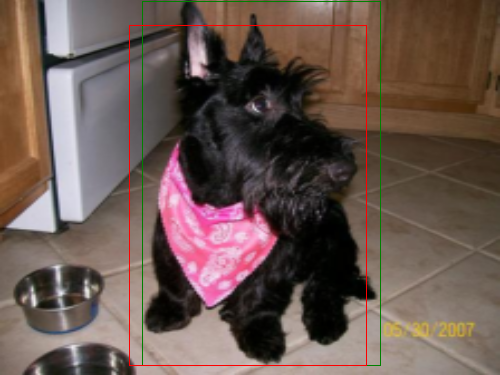

In [204]:
item = next(iter(val_loader))
i = 0
im = item['image'][i]
bbox = item['bbox'][i]
shape = (item['shape'][0][i].item(), item['shape'][1][i].item())
label = item['label'][i]
with torch.no_grad():
    pred_prob, pred_bbox = model(im.unsqueeze(0).cuda())
draw_image_with_bbox(im, shape, bbox, label, pred_bbox[0].cpu(), pred_prob[0].cpu())

## Save model

In [262]:
torch.save(model.state_dict(), './dog-localization/model.pt')